In [31]:
import autograd.numpy as np
from autograd.numpy import random as npr
npr.seed(0)
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam

import pyemma
import matplotlib.pyplot as plt
#%matplotlib inline

def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        print(mean.shape, log_std.shape)
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

class NeuralApproximatePropagator():
    '''Use a multilayer perceptron to approximate the top m eigenfunctions 
    of the Markov propagator that generated your time series.
    
    Parts of this are adapted from the autograd example
    
    https://github.com/HIPS/autograd/blob/master/examples/neural_net.py
    '''
    
    def __init__(self,
                 lag = 10,
                 m = 2,
                 hidden_layer_dims = [256, 64],
                 minibatch_size = 5000,
                 param_scale = 0.1,
                 nonlinearity=lambda x:np.maximum(0, x)
                ):
        '''
        lag : lag-time for estimation
        m : number of propagator eigenfunctions to recover
        hidden_layer_dims : dimensions of hidden layers
        minibatch_size : number of time-lagged observation pairs per minibatch
        param_scale : MLP weights are randomly initialized
        nonlinearity : elementwise nonlinear function (default: ReLU)
        
        special case:
        - should recover tICA if `hidden_layer_dims=[]` and `nonlinearity=lambda x:x`
        '''
        self.lag = lag
        self.m = m
        self.hidden_layer_dims = list(hidden_layer_dims)
        self.minibatch_size = minibatch_size
        self.param_scale = 0.1
        self.nonlinearity = nonlinearity
        
    def rayleigh_quotient(self, X_0_minus_tau, X_tau):
        '''trace of P Q^{-1}
        where:
        - $P_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot (\mathcal{P} \circ f_j(x))]$ and
        - $Q_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot f_j(x)]$.'''
        P = np.dot(X_0_minus_tau.T, X_tau) / len(X_tau)
        Q = np.dot(X_0_minus_tau.T, X_0_minus_tau) / len(X_0_minus_tau)
        return np.trace(np.dot(P, np.linalg.inv(Q)))
    
    def neural_net_predict(self, params, inputs):
        for W, b in params:
            outputs = np.dot(inputs, W) + b
            inputs = self.nonlinearity(outputs)
        return outputs
    
    def predict(self, X):
        return [self.neural_net_predict(self.params, x) for x in X]

    def init_random_params(self, scale, layer_sizes, rs=npr.RandomState(0)):
        return [(scale * rs.randn(m, n),   # weight matrix
                 scale * rs.randn(n))      # bias vector
                for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]
    
    def fit(self, X, num_iters = 1000, step_size = 0.001):
        stacked_X = np.vstack([x[:-self.lag] for x in X])
        stacked_Y = np.vstack([x[self.lag:] for x in X])
        dim = X[0].shape[1]

        layer_sizes = [dim] + self.hidden_layer_dims + [self.m]
        init_params = self.init_random_params(self.param_scale, layer_sizes)
        print([(W.shape, b.shape) for (W,b) in init_params])
        num_weights = np.sum([np.prod(W.shape) + np.prod(b.shape) for (W,b) in init_params])
        print(num_weights)
        
        def log_posterior(params, iter):
            ''' minibatch estimator of -log(rayleigh quotient)
            `iter` specifies a minibatch
            '''
            inds = np.arange(len(stacked_X))
            rs = npr.RandomState(iter)
            rs.shuffle(inds)
            inds = inds[:self.minibatch_size]
            
            x = self.neural_net_predict(params, stacked_X[inds])
            y = self.neural_net_predict(params, stacked_Y[inds])
            
            return np.log(self.rayleigh_quotient(x, y))

        # Build variational objective.
        objective, objective_grad, unpack_params = \
            black_box_variational_inference(log_posterior, num_weights,
                                            num_samples=20)

        print("     Epoch     |       Rayleigh Quotient")
        def save_params_and_print_perf(params, iter, gradient, report_interval = 100):
            self.params = params
            if iter % report_interval == 0:
                x = self.neural_net_predict(params, stacked_X)
                y = self.neural_net_predict(params, stacked_Y)
                rq = self.rayleigh_quotient(x, y)
                print("{:15}|{:20}".format(iter//report_interval, rq))

        self.params = adam(objective_grad, init_params, step_size=step_size,
                                num_iters=num_iters, callback=save_params_and_print_perf)
        return self

In [32]:
# instead of having a deep network, we could just have a mixture of gaussians?
# we want to find means and variances for gaussian basis functions

In [33]:
from msmbuilder.example_datasets import MetEnkephalin
from msmbuilder.featurizer import DihedralFeaturizer
X = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4']).fit_transform(MetEnkephalin().get().trajectories)

met_enkephalin already is cached


In [34]:
m = 2
lag = 100
adaptive_vac = NeuralApproximatePropagator(lag = lag, m = m)
adaptive_vac.fit(X)

[((38, 256), (256,)), ((256, 64), (64,)), ((64, 2), (2,))]
26562
     Epoch     |       Rayleigh Quotient


AttributeError: 'ListNode' object has no attribute 'shape'

In [35]:
def make_nn_funs(layer_sizes, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs
    
    return num_weights, predictions

In [64]:
import autograd.numpy as np
from autograd.numpy import random as npr
npr.seed(0)
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam

import pyemma
import matplotlib.pyplot as plt
#%matplotlib inline

def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        if t == -1: print('\tVariational lower bound: {0:.3f}'.format(lower_bound))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

class NeuralApproximatePropagator():
    '''Use a multilayer perceptron to approximate the top m eigenfunctions 
    of the Markov propagator that generated your time series.
    
    Parts of this are adapted from the autograd example
    
    https://github.com/HIPS/autograd/blob/master/examples/neural_net.py
    '''
    
    def __init__(self,
                 lag = 10,
                 m = 2,
                 hidden_layer_dims = [256, 64],
                 minibatch_size = 5000,
                 param_scale = 0.1,
                 nonlinearity=lambda x:np.maximum(0, x)
                ):
        '''
        lag : lag-time for estimation
        m : number of propagator eigenfunctions to recover
        hidden_layer_dims : dimensions of hidden layers
        minibatch_size : number of time-lagged observation pairs per minibatch
        param_scale : MLP weights are randomly initialized
        nonlinearity : elementwise nonlinear function (default: ReLU)
        
        special case:
        - should recover tICA if `hidden_layer_dims=[]` and `nonlinearity=lambda x:x`
        '''
        self.lag = lag
        self.m = m
        self.hidden_layer_dims = list(hidden_layer_dims)
        self.minibatch_size = minibatch_size
        self.param_scale = 0.1
        self.nonlinearity = nonlinearity
        
    def rayleigh_quotient(self, X_0_minus_tau, X_tau):
        '''trace of P Q^{-1}
        where:
        - $P_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot (\mathcal{P} \circ f_j(x))]$ and
        - $Q_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot f_j(x)]$.'''
        P = np.dot(X_0_minus_tau.T, X_tau) / len(X_tau)
        Q = np.dot(X_0_minus_tau.T, X_0_minus_tau) / len(X_0_minus_tau)
        return np.trace(np.dot(P, np.linalg.inv(Q)))
    
    def predict(self, X):
        return [self.neural_net_predict(self.params, x) for x in X]
    
    def fit(self, X, num_iters = 1000, step_size = 0.001):
        stacked_X = np.vstack([x[:-self.lag] for x in X])
        stacked_Y = np.vstack([x[self.lag:] for x in X])
        dim = X[0].shape[1]
        
        layer_sizes = [dim] + self.hidden_layer_dims + [self.m]
        
        self.num_weights, self.neural_net_predict = \
            make_nn_funs(layer_sizes=layer_sizes,
                         noise_variance=0.01, nonlinearity=self.nonlinearity)
        
        def log_posterior(params, iter):
            ''' minibatch estimator of -log(rayleigh quotient)
            `iter` specifies a minibatch. when iter=-1, we evaluate on the full dataset
            '''
            inds = np.arange(len(stacked_X))
            if iter >= 0:
                rs = npr.RandomState(iter)
                rs.shuffle(inds)
                inds = inds[:self.minibatch_size]
            
            x = self.neural_net_predict(params, stacked_X[inds])
            y = self.neural_net_predict(params, stacked_Y[inds])
            
            # if we're dealing with multiple parameter samples
            if len(x.shape) > 2:
                rqs = [self.rayleigh_quotient(x[i], y[i]) for i in range(len(x))]
                rq = np.mean(rqs)
            else:
                rq = self.rayleigh_quotient(x, y)
            
            if iter == -1:
                print('\tRayleigh Quotient: {0:.3f}'.format(rq))
            
            return np.log(rq)
        
        init_mean = npr.randn(self.num_weights) * self.param_scale
        init_log_std = -5 * np.ones(self.num_weights)
        init_var_params = np.concatenate([init_mean, init_log_std])
        self.params = init_var_params
        
        # Build variational objective.
        variational_objective, variational_grad, unpack_params = \
            black_box_variational_inference(log_posterior, self.num_weights,
                                            num_samples=20)

        def save_params_and_print_perf(params, iter, gradient, report_interval = 100):
            self.params = params
            if iter % report_interval == 0: print('Epoch {0}'.format(iter))
        
        self.params = adam(variational_grad, init_var_params,
                           step_size=step_size, num_iters=num_iters,
                           callback=save_params_and_print_perf)
        return self

In [65]:
m = 2
lag = 100
n_frames = len(np.vstack(X)) - lag

adaptive_vac = NeuralApproximatePropagator(lag = lag, m = m, hidden_layer_dims=[10])
adaptive_vac.fit(X)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


<__main__.NeuralApproximatePropagator instance at 0x11564bcf8>

In [69]:
adaptive_vac.num_weights

412

In [76]:
w = adaptive_vac.params.reshape((1,2*adaptive_vac.num_weights))
w.shape

(1, 824)

In [77]:
X_nc = [adaptive_vac.neural_net_predict(w, x) for x in X]

In [78]:
X_nc[0].shape

(1, 9979, 2)

In [79]:
D = adaptive_vac.num_weights
num_samples = 20
mean, log_std = adaptive_vac.params[:D], adaptive_vac.params[D:]
samples = rs.randn(num_samples, D) * np.exp(log_std) + mean

In [80]:
X_nc = [adaptive_vac.neural_net_predict(samples, x) for x in X]

In [81]:
samples.shape

(20, 412)

In [82]:
X_nc[0].shape

(20, 9979, 2)

In [96]:

transformed[0].shape

(9979, 2)

In [99]:
rqs = []
for i in range(num_samples):
    transformed = [x[i] for x in X_nc]
    x_0 = np.vstack([t[:-lag] for t in transformed])
    x_tau = np.vstack([t[lag:] for t in transformed])
    rqs.append(adaptive_vac.rayleigh_quotient(x_0, x_tau))

In [104]:
np.mean(rqs), np.std(rqs)

(1.9240316857489415, 0.0012767478441818667)

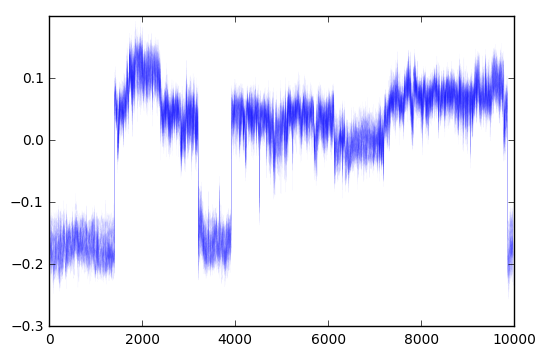

In [92]:
for x in X_nc[0]: plt.plot(x[:,0]-np.mean(x[:,0]), color='blue', alpha=0.1, linewidth=0.1)

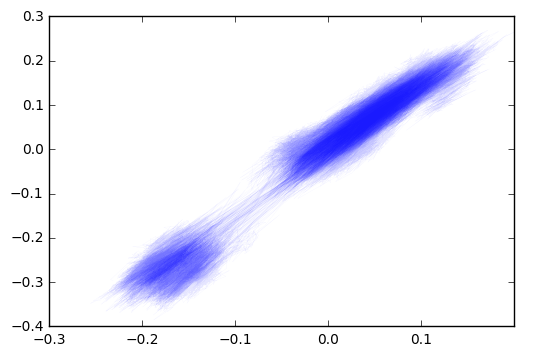

In [93]:
for x in X_nc[0]:
    x_ = x - np.mean(x,0)
    plt.plot(x_[:,0], x_[:,1], color='blue', alpha=0.1, linewidth=0.1)

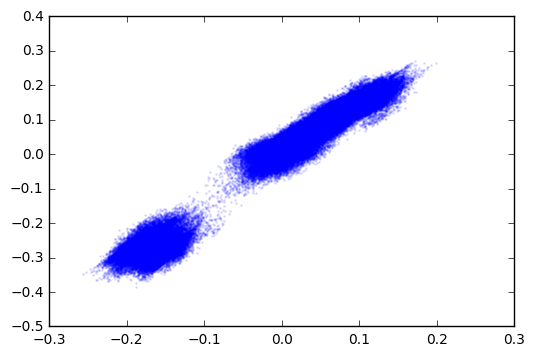

In [94]:
for x in X_nc[0]:
    x_ = x - np.mean(x,0)
    plt.scatter(x_[:,0], x_[:,1], color='blue', alpha=0.1, s=1)

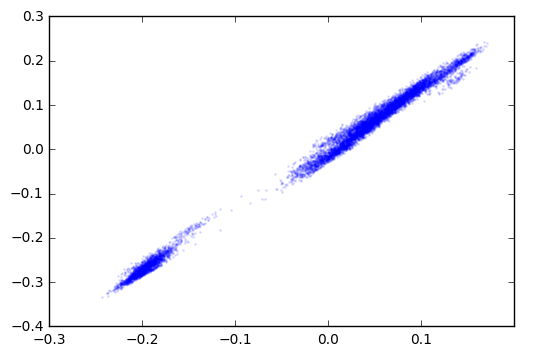

In [95]:
for x in X_nc[0][:1]:
    x_ = x - np.mean(x,0)
    plt.scatter(x_[:,0], x_[:,1], color='blue', alpha=0.1, s=1)